# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## 1. Откройте файл с данными и изучите общую информацию.

### 1.1. Инициализация DataFrame

In [1]:
import pandas as pd

try:
  data = pd.read_csv('../datasets/real_estate_data.csv', sep='\t')
except:
  data = pd.read_csv('real_estate_data.csv', sep='\t')

In [2]:
import warnings

warnings.filterwarnings("ignore")

### 1.2. Информация о DataFrame

#### 1.2.1. О столбцах и типах данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### 1.2.2. Описание данных
+ airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
+ balcony — число балконов
+ ceiling_height — высота потолков (м)
+ city_centers_nearest — расстояние до центра города (м)
+ days_exposition — сколько дней было размещено объявление (от публикации до снятия)
+ first_day_exposition — дата публикации
+ floor — этаж
+ floors_total — всего этажей в доме
+ is_apartment — апартаменты (булев тип)
+ kitchen_area — площадь кухни в квадратных метрах (м²)
+ last_price — цена на момент снятия с публикации
+ living_area — жилая площадь в квадратных метрах (м²)
+ locality_name — название населённого пункта
+ open_plan — свободная планировка (булев тип)
+ parks_around3000 — число парков в радиусе 3 км
+ parks_nearest — расстояние до ближайшего парка (м)
+ ponds_around3000 — число водоёмов в радиусе 3 км
+ ponds_nearest — расстояние до ближайшего водоёма (м)
+ rooms — число комнат
+ studio — квартира-студия (булев тип)
+ total_area — общая площадь квартиры в квадратных метрах (м²)
+ total_images — число фотографий квартиры в объявлении

#### 1.2.3. Первые 5 строк данных таблицы

In [4]:
data = data.rename(columns={
    'cityCenters_nearest': 'city_centers_nearest'
})

In [5]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### 1.3. Гистограммы для всех столбцов таблицы

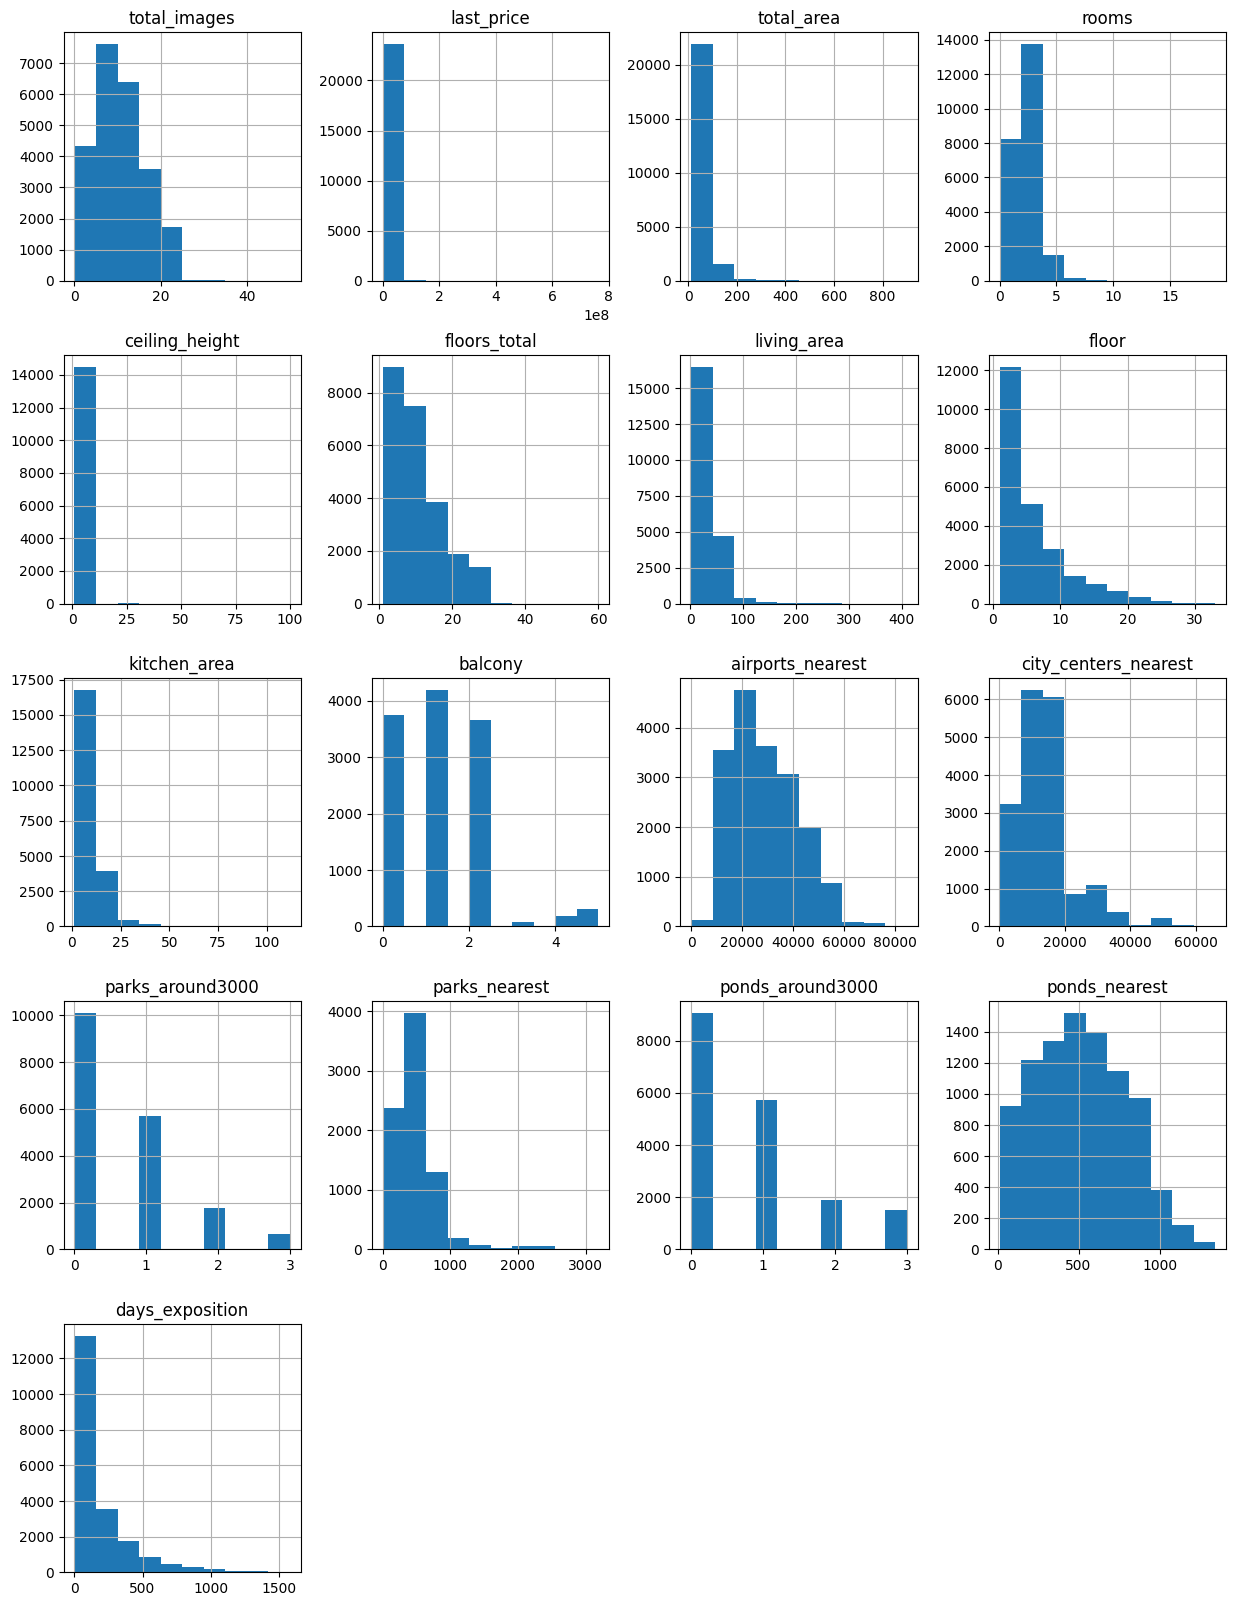

In [6]:
data.hist(figsize=(15, 20))
None

<div class="alert alert-info">
<b>
    <strong>Комментарий</strong>
    <br>
    1) В данных есть пропуски, проработаем их ниже
    <br>
    2) Есть неправильные типы данных, проработаем их ниже
    <br>
    3) В данных есть выбросы и анамалии, проработаем их ниже
</b> 
</div>

## 2. Предобработка данных

### 2.1. Работа с пропусками

#### 2.1.1. Определим в каких столбцах есть пропуски

In [7]:
series_empty_columns = data.isna().sum()
series_empty_columns = series_empty_columns.loc[series_empty_columns != 0]
empty_columns_list = series_empty_columns.index.to_list()
empty_columns_list.remove('locality_name')
empty_columns_list.remove('is_apartment')
print(empty_columns_list)

['ceiling_height', 'floors_total', 'living_area', 'kitchen_area', 'balcony', 'airports_nearest', 'city_centers_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']


##### Список столбцов с пропусками
+ ~~airports_nearest~~ — расстояние до ближайшего аэропорта в метрах (м)
+ ~~balcony~~ — число балконов
+ ~~ceiling_height~~ — высота потолков (м)
+ ~~city_centers_nearest~~ — расстояние до центра города (м)
+ ~~days_exposition~~ — сколько дней было размещено объявление (от публикации до снятия)
+ ~~floors_total~~ — всего этажей в доме
+ ~~is_apartment~~ — апартаменты (булев тип)
+ ~~kitchen_area~~ — площадь кухни в квадратных метрах (м²)
+ ~~living_area~~ — жилая площадь в квадратных метрах (м²)
+ ~~locality_name~~ — название населённого пункта
+ ~~parks_around3000~~ — число парков в радиусе 3 км
+ ~~parks_nearest~~ — расстояние до ближайшего парка (м)
+ ~~ponds_around3000~~ — число водоёмов в радиусе 3 км
+ ~~ponds_nearest~~ — расстояние до ближайшего водоёма (м)

#### 2.1.2. Заполнение пропусков

Возможно будем заполнять пропуски с помощью алгоритма классификации knn
Для этоого посмотрим на матрице графиков, возможно ли применения knn

In [8]:
import seaborn as sns

empty_data = data[empty_columns_list].copy()

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# sns.pairplot(empty_data, hue='balcony')

In [ ]:
# sns.pairplot(empty_data, hue='ceiling_height')

В данных много выбросов, чистить от выбрасов буду позже, сейчас knn не применим

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Небольшие замечания и рекомендации💡:</b> Действительно, было бы здорвоо еще поределить ,сколько % прпоусков в стобцах

In [ ]:
procent = series_empty_columns / data.shape[0] * 100
procent

ceiling_height          38.799105
floors_total             0.362885
living_area              8.029875
is_apartment            88.290645
kitchen_area             9.612220
balcony                 48.605426
locality_name            0.206760
airports_nearest        23.384953
city_centers_nearest    23.287902
parks_around3000        23.283683
parks_nearest           65.909954
ponds_around3000        23.283683
ponds_nearest           61.559559
days_exposition         13.422507
dtype: float64

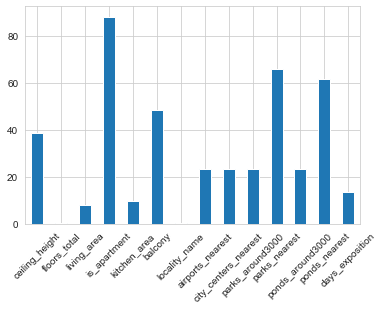

In [ ]:
procent.plot.bar(rot=45)
None

<div class="alert alert-info">
<b>
    <strong>Комментарий</strong>
    <br>
    Добавил % пропусков в каждом из столбцов
    <br> 
    Добавил столбчатую диаграмму
</b> 
</div>

##### 2.1.2.1. balcony — число балконов

In [ ]:
data.balcony = data.balcony.fillna(0)
data.balcony.isna().sum()

0

1. **Причина** пропусков данных в этом столбце связана с тем, что в случае отсутствия балкона у людей, они просто ничего
не писали в ячейку формы (количество балконов)
2. Тип пропусков **MAR**
3. **Предлагаемое решение** - поле *selection* что бы пользователи сервиса сделали выбор из списка возможного числа балконов, на основе обработанных мной данных это [0, 1, 2, 3, 4, 5, 6]

##### 2.1.2.2. is_apartment — апартаменты (булев тип)

Посмотрим на распределение значений в этом столбце, так же будем учитывать что из 23699 строк в 20924 нет информации
об апартаментах

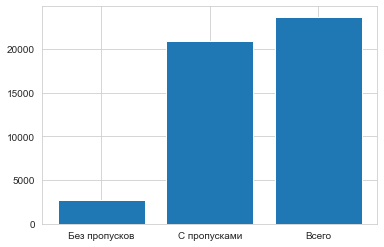

In [ ]:
from matplotlib import pyplot as plt

vals = [data.shape[0] - data.is_apartment.isna().sum(), data.is_apartment.isna().sum(), data.shape[0]]
indexes = ['Без пропусков', 'C пропусками', 'Всего']
plt.bar(indexes, vals)
None

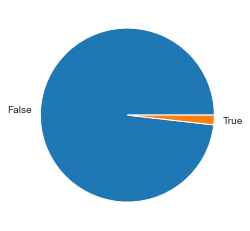

In [ ]:
data.is_apartment.value_counts()

data.is_apartment.value_counts().plot(kind='pie', label='')
None

Большинство квартир имеющих информацию в столбце is_apartment не являются апатраментами,
следовательно заполним пропуски False. NaN -> False

In [ ]:
data.is_apartment = data.is_apartment.fillna(False)
data.is_apartment.isna().sum()

0

1. **Причина** пропусков данных в этом столбце связана с тем, что в случае не апартаменты, они просто ничего
не писали в ячейку формы (апартаменты?)
2. Тип пропусков **MAR**
3. **Предлагаемое решение** - поле *selection* что бы пользователи сервиса сделали выбор из списка [апартаменты, не  апартаменты]

##### 2.1.2.3. days_exposition — сколько дней было размещено объявление (от публикации до снятия)

In [ ]:
data.days_exposition.value_counts()

45.0      880
60.0      538
7.0       234
30.0      208
90.0      204
         ... 
1021.0      1
1362.0      1
1105.0      1
795.0       1
971.0       1
Name: days_exposition, Length: 1141, dtype: int64

1. **Причина** техническая ошибка, тк даты публикации и снятия объявления должны храниться в БД.
2. **Тип данных** - данные количественные
2. Тип пропусков **MNAR**
3. **Предлагаемое решение** - заполнение будет медианным значением, для того что бы снизить влияние аномальных значений

In [ ]:
#data.days_exposition = data.days_exposition.fillna(data.days_exposition.median())
data.days_exposition.isna().sum()

3181

In [ ]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data['year'] = data.first_day_exposition.dt.year
data['days_exposition_NaN'] = data['days_exposition'].isna()
data['days_exposition_all'] = 1
days_exposition_pt = data.pivot_table(
    index=['year'], 
    values=['days_exposition', 'days_exposition_NaN', 'days_exposition_all'], 
    aggfunc=['count', 'sum']
)
days_exposition_pt['procent_NaN'] = (
    days_exposition_pt[('sum', 'days_exposition_NaN')] 
    / days_exposition_pt[('count', 'days_exposition_all')] 
    * 100
)
data = data.drop(columns=['days_exposition_NaN', 'days_exposition_all'])
days_exposition_pt =days_exposition_pt.drop(
    columns=[
        ('sum', 'days_exposition_all'), ('sum', 'days_exposition'),
        ('count', 'days_exposition_NaN')
    ]
)
days_exposition_pt

count                                     sum procent_NaN
     days_exposition days_exposition_all days_exposition_NaN            
year                                                                    
2014             119                 137                  18   13.138686
2015            1121                1191                  70    5.877414
2016            2716                2783                  67    2.407474
2017            7919                8190                 271    3.308913
2018            7560                8519                 959   11.257190
2019            1083                2879                1796   62.382772

<div class="alert alert-info">
    <h2>Комментарий студента</h2>
    <b>
    Как мы видим из сводной таблицы, наибольший процент пропусков в 2019 последним на момент выгрузки данных году, это значит что большинство квартир просто не успели продасться
    </b> 
</div>

Данные о продажах за последний год удалим

In [ ]:
years = days_exposition_pt.index.to_list()
data = data.loc[(data.year != 2019) | (data.days_exposition.isna() != True)]

заполним пропуски в данных за другие года

In [ ]:
data.days_exposition = data.days_exposition.fillna(data.days_exposition.median())

##### 2.1.2.4. locality_name — название населённого пункта

In [ ]:
data.locality_name = data.locality_name.fillna("Неизвестно")
data.locality_name.isna().sum()

0

1. **Причина** возможно техническая ошибка, тк я уверен что "населенный пункт" - обязательное поле в объявлении. И что оно определено автоматически используя геолокацию пользователя.
2. **Тип данных** - данные категориальные
3. Тип пропусков **MNAR**
4. **Предлагаемое решение** - заполнение будет "неизвестно"

##### 2.1.2.5. ceiling_height — высота потолков (м)

In [ ]:
error_ceiling_height = data.ceiling_height.value_counts().sort_index().to_dict()
print(error_ceiling_height)

{1.0: 1, 1.2: 1, 1.75: 1, 2.0: 10, 2.2: 1, 2.25: 1, 2.3: 4, 2.34: 1, 2.4: 20, 2.45: 14, 2.46: 2, 2.47: 3, 2.48: 7, 2.49: 1, 2.5: 3127, 2.51: 32, 2.52: 73, 2.53: 58, 2.54: 76, 2.55: 889, 2.56: 123, 2.57: 96, 2.58: 55, 2.59: 13, 2.6: 1503, 2.61: 4, 2.62: 14, 2.63: 11, 2.64: 68, 2.65: 603, 2.66: 16, 2.67: 32, 2.68: 23, 2.69: 2, 2.7: 1444, 2.71: 11, 2.72: 30, 2.73: 31, 2.74: 26, 2.75: 851, 2.76: 58, 2.77: 57, 2.78: 42, 2.79: 10, 2.8: 895, 2.81: 8, 2.82: 16, 2.83: 12, 2.84: 17, 2.85: 92, 2.86: 6, 2.87: 9, 2.88: 11, 2.89: 1, 2.9: 142, 2.91: 3, 2.92: 8, 2.93: 4, 2.94: 2, 2.95: 39, 2.96: 5, 2.97: 4, 2.98: 2, 2.99: 1, 3.0: 1014, 3.01: 5, 3.02: 7, 3.03: 4, 3.04: 6, 3.05: 44, 3.06: 11, 3.07: 8, 3.08: 13, 3.09: 2, 3.1: 187, 3.11: 5, 3.12: 15, 3.13: 11, 3.14: 6, 3.15: 52, 3.16: 6, 3.17: 5, 3.18: 10, 3.2: 241, 3.21: 2, 3.22: 3, 3.23: 3, 3.24: 4, 3.25: 32, 3.26: 5, 3.27: 6, 3.28: 5, 3.29: 1, 3.3: 133, 3.31: 3, 3.32: 4, 3.33: 10, 3.34: 3, 3.35: 15, 3.36: 4, 3.37: 3, 3.38: 8, 3.39: 1, 3.4: 82, 3.42: 1,

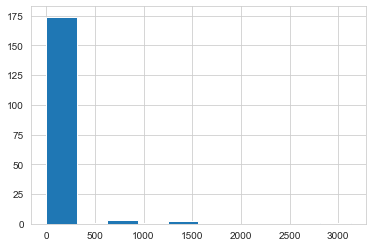

In [ ]:
data.ceiling_height.value_counts().hist(bins=10)
None

Мы видим большое число пропусков и выбрасов в этих данных, сначала избавимся от выбрасов затем заполним пропускки

Пример:
20.0: 1,
22.6: 1,
24.0: 1,
25.0: 7,
26.0: 1,
27.0: 8,
27.5: 1,
32.0: 2,
100.0: 1

In [ ]:
data.ceiling_height.mean()

2.7704321316972305

In [ ]:
error_ceiling_height_list: list = []
for ceiling_height in error_ceiling_height.keys():
    if ceiling_height >= 20:
        data.ceiling_height.loc[data.ceiling_height == ceiling_height] = ceiling_height / 10
data.ceiling_height.mean()

2.7312590503772123

In [ ]:
data.ceiling_height.median()

2.65

In [ ]:
data.ceiling_height.value_counts().sort_index()

1.00      1
1.20      1
1.75      1
2.00     10
2.20      1
         ..
8.00      3
8.30      1
10.00     1
10.30     1
14.00     1
Name: ceiling_height, Length: 176, dtype: int64

Уберем строки с выбивающимися значениями

In [ ]:
data.ceiling_height = data.ceiling_height.fillna(data.ceiling_height.median())

In [ ]:
data = data.loc[(2.00 <= data.ceiling_height) & (data.ceiling_height <= 10)]
data.shape[0]

21898

In [ ]:
data.ceiling_height.isna().sum()

0

1. **Причина** возможно техническая ошибка, тк я уверен что "высота потолков" - обязательное поле в объявлении.
2. **Выбросы** Данные имеют выбросы (аномальные значения), считаю что в форме объявления нужно поставить проверку на диапазон вводимых значений.
3. **Тип данных** - данные количественные
4. Тип пропусков **MNAR**
5. **Предлагаемое решение** - заполнение будет медианным значением, для того что бы снизить влияние аномальных значений, так же хочу заметить что аномальные значения были ликвидированы до заполнения пропусков, строки со занчениями которые не получилось привести в нормальную форму удалены.

In [ ]:
data.ceiling_height.value_counts().sort_index()

2.00     10
2.20      1
2.25      1
2.26      1
2.30      4
         ..
5.80      1
6.00      1
8.00      3
8.30      1
10.00     1
Name: ceiling_height, Length: 171, dtype: int64

##### 2.1.2.6. airports_nearest — расстояние до ближайшего аэропорта в метрах (м)

In [ ]:
airport_pivot_table = data.pivot_table(
    index=['locality_name'],
    values=['airports_nearest', 'city_centers_nearest'],
    aggfunc='count'
)

airport_pivot_table.loc[airport_pivot_table['airports_nearest'] != airport_pivot_table['city_centers_nearest']]

,airports_nearest,city_centers_nearest
locality_name,,
Санкт-Петербург,14453,14477


Квартиры находящиеся в одном городе, у которых пропущено или расстояние до ближайшего аэропорта или расстояние до
центра города, была идея для квартир с пропущенным расстоянием до аэропорта заполнять пропуски расстоянием до аэропорта
у соответствующих (по расстоянию от центра) квартир


Но эта идея не имеет права на существование, тк
1. Квартир с подходящими пропусками 25шт, это 0.1% от датасета, игра не стоит свеч
2. Квартира может находиться диаметрально противоположено относительно центра города, относительно другой квартиры (В таком случае расстояние до цента у них будет одинаковое, а до аэропорта кратно отличаться)

In [ ]:
data.airports_nearest = data.airports_nearest.fillna(data.airports_nearest.median())
data.airports_nearest.isna().sum()

0

1. **Причина** техническая ошибка, тк эти данные должны быть заполнены автоматически (они получены картографически)
2. Тип пропусков **MAR**
3. **Предлагаемое решение**: Заполнение данных медианой

##### 2.1.2.7. city_centers_nearest — расстояние до центра города (м)

In [ ]:
data.city_centers_nearest = data.city_centers_nearest.fillna(data.city_centers_nearest.median())
data.city_centers_nearest.isna().sum()

0

1. **Причина** техническая ошибка, тк эти данные должны быть заполнены автоматически (они получены картографически)
2. Тип пропусков **MAR**
3. **Предлагаемое решение**: Заполнение данных медианой

##### 2.1.2.8. floors_total — всего этажей в доме

In [ ]:
data.floors_total.value_counts()

5.0     5291
9.0     3462
16.0    1270
12.0    1256
4.0     1110
10.0    1094
25.0    1026
6.0      850
17.0     757
3.0      614
7.0      540
14.0     511
18.0     474
24.0     437
8.0      362
2.0      344
15.0     342
23.0     331
19.0     324
22.0     274
20.0     263
13.0     216
11.0     181
21.0     154
27.0     152
26.0     115
35.0      22
1.0       22
28.0      19
36.0       2
34.0       1
60.0       1
29.0       1
33.0       1
52.0       1
Name: floors_total, dtype: int64

In [ ]:
data.floors_total.median()

9.0

Нельзя просто заполнить средним

In [ ]:
data.floors_total.isna().sum()

78

Тк таких пропусков 0.3% удалим строки с пропусками в этом столбце

In [ ]:
data = data.loc[data.floors_total.isna() == False]
data.floors_total.isna().sum()

0

In [ ]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.6,1,False,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2018
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.3,4,False,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2015
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,NaN,9,False,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2015
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,2018
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.4,5,False,...,0.0,городской посёлок Янино-1,26723.5,13106.0,NaN,NaN,NaN,NaN,55.0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,95.0,2017
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5.0,38.0,4,False,...,0.0,Тосно,26723.5,13106.0,NaN,NaN,NaN,NaN,45.0,2018
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3.0,29.7,1,False,...,0.0,село Рождествено,26723.5,13106.0,NaN,NaN,NaN,NaN,95.0,2018
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,NaN,12,False,...,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,2017


1. **Причина** человеческий фактор
2. **Тип данных** - данные категориальные (число этажей в доме ограничено)
3. Тип пропусков **MAR**
4. **Предлагаемое решение** - удаление строк с пропущенными значениями.

##### 2.1.2.9. kitchen_area — площадь кухни в квадратных метрах (м²)

In [ ]:
data.kitchen_area.value_counts()

6.00     1203
10.00    1189
9.00     1025
8.00     1022
7.00      988
         ... 
2.40        1
3.70        1
5.82        1
8.73        1
13.83       1
Name: kitchen_area, Length: 930, dtype: int64

In [ ]:
data.kitchen_area.median()

9.2

In [ ]:
data.kitchen_area = data.kitchen_area.fillna(data.kitchen_area.median())
data.kitchen_area.isna().sum()

0

1. **Причина** человеческий фактор
2. **Тип данных** - данные количественные
3. Тип пропусков **MAR**
4. **Предлагаемое решение** - заполнение медианой, еще раз повторюсь, считаю что все поля должны быть обязательными.
4.1. Так же аналитик данных должен получать информацию, какие поля в объявлении обязательны для заполнения, а какие нет.

##### 2.1.2.10. living_area — жилая площадь в квадратных метрах (м²)

In [ ]:
data.living_area.value_counts()

18.00     823
17.00     630
30.00     542
16.00     465
20.00     452
         ... 
28.86       1
76.70       1
124.90      1
36.07       1
42.55       1
Name: living_area, Length: 1700, dtype: int64

In [ ]:
data.living_area.median()

30.0

In [ ]:
print("is NaN =", data.living_area.isna().sum(), "rows")
print("all / NaN =", round(data.living_area.isna().sum() / data.shape[0] * 100, 2), '%')

is NaN = 1755 rows
all / NaN = 8.04 %


1. **Причина** человеческий фактор
2. **Тип данных** - данные количественные
3. Тип пропусков **MAR**
4. **Предлагаемое решение** - удаление строк, тк это ключевой показатель.
4.1. Еще раз повторюсь, считаю что все поля должны быть обязательными.
4.2. Так же аналитик данных должен получать информацию, какие поля в объявлении обязательны для заполнения, а какие нет.

In [ ]:
data = data.loc[data.living_area.isna() == False]
data.living_area.isna().sum()

0

##### 2.1.2.11. parks_around3000 — число парков в радиусе 3 км

In [ ]:
data['parks_around3000'] = data['parks_around3000'].fillna(data['parks_around3000'].mean())
data['parks_around3000'].isna().sum()

0

1. **Причина** техническая ошибка, тк данные должны были быть получены картографически
2. **Тип данных** - данные количественные
3. Тип пропусков **MAR**
4. **Предлагаемое решение** - заполнение средним

##### 2.1.2.12. parks_nearest — расстояние до ближайшего парка (м)

In [ ]:
data['parks_nearest'] = data['parks_nearest'].fillna(data['parks_nearest'].mean())
data['parks_nearest'].isna().sum()

0

1. **Причина** техническая ошибка, тк данные должны были быть получены картографически
2. **Тип данных** - данные количественные
3. Тип пропусков **MAR**
4. **Предлагаемое решение** - заполнение средним

##### 2.1.2.13. ponds_around3000 — число водоёмов в радиусе 3 км

In [ ]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(data['ponds_around3000'].mean())
data['ponds_around3000'].isna().sum()

0

1. **Причина** техническая ошибка, тк данные должны были быть получены картографически
2. **Тип данных** - данные количественные
3. Тип пропусков **MAR**
4. **Предлагаемое решение** - заполнение средним

##### 2.1.2.14. ponds_nearest — расстояние до ближайшего водоёма (м)

In [ ]:
data['ponds_nearest'] = data['ponds_nearest'].fillna(data['ponds_nearest'].mean())
data['ponds_nearest'].isna().sum()

0

1. **Причина** техническая ошибка, тк данные должны были быть получены картографически
2. **Тип данных** - данные количественные
3. Тип пропусков **MAR**
4. **Предлагаемое решение** - заполнение средним

##### 2.1.2.15. Проверка

In [ ]:
data.isna().sum()

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
city_centers_nearest    0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
year                    0
dtype: int64

### 2.2. Обработка типов данных

#### 2.2.1. Посмотрим на данные

In [ ]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.6,1,False,...,2.0,посёлок Шушары,12817.0,18603.0,0.000000,488.394714,0.000000,520.108031,81.0,2018
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.3,4,False,...,0.0,Санкт-Петербург,21741.0,13933.0,1.000000,90.000000,2.000000,574.000000,558.0,2015
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,0.0,Санкт-Петербург,31856.0,8098.0,2.000000,112.000000,1.000000,48.000000,121.0,2018
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.4,5,False,...,0.0,городской посёлок Янино-1,26723.5,13106.0,0.611385,488.394714,0.765049,520.108031,55.0,2018
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,10.6,6,False,...,1.0,посёлок Парголово,52996.0,19143.0,0.000000,488.394714,0.000000,520.108031,155.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23693,9,4600000.0,62.40,2016-08-05,3,2.60,9.0,40.0,8,False,...,0.0,Петергоф,45602.0,34104.0,1.000000,352.000000,1.000000,675.000000,239.0,2016
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,0.0,Санкт-Петербург,24665.0,4232.0,1.000000,796.000000,3.000000,381.000000,95.0,2017
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5.0,38.0,4,False,...,0.0,Тосно,26723.5,13106.0,0.611385,488.394714,0.765049,520.108031,45.0,2018
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3.0,29.7,1,False,...,0.0,село Рождествено,26723.5,13106.0,0.611385,488.394714,0.765049,520.108031,95.0,2018


#### 2.2.2. Посмотрим на типы данных

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20065 entries, 1 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20065 non-null  int64         
 1   last_price            20065 non-null  float64       
 2   total_area            20065 non-null  float64       
 3   first_day_exposition  20065 non-null  datetime64[ns]
 4   rooms                 20065 non-null  int64         
 5   ceiling_height        20065 non-null  float64       
 6   floors_total          20065 non-null  float64       
 7   living_area           20065 non-null  float64       
 8   floor                 20065 non-null  int64         
 9   is_apartment          20065 non-null  bool          
 10  studio                20065 non-null  bool          
 11  open_plan             20065 non-null  bool          
 12  kitchen_area          20065 non-null  float64       
 13  balcony         

#### 2.2.3. Изменим типы данных

In [ ]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

In [ ]:
data = data.astype({
    'total_images': 'uint8',
    'last_price': 'uint32',
    'total_area': 'uint16',
    'rooms': 'uint8',
    'ceiling_height': 'float16',
    'floors_total': 'uint8',
    'living_area': 'float16',
    'floor': 'uint8',
    'kitchen_area': 'float16',
    'balcony': 'uint8',
    'airports_nearest': 'uint16',
    'city_centers_nearest': 'uint16',
    'parks_around3000': 'uint8',
    'parks_nearest': 'uint16',
    'ponds_nearest': 'uint16',
    'ponds_around3000': 'uint8',
    'days_exposition': 'uint16'
})

Комментарий по поводу изменения типов данных:


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20065 entries, 1 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20065 non-null  uint8         
 1   last_price            20065 non-null  uint32        
 2   total_area            20065 non-null  uint16        
 3   first_day_exposition  20065 non-null  datetime64[ns]
 4   rooms                 20065 non-null  uint8         
 5   ceiling_height        20065 non-null  float16       
 6   floors_total          20065 non-null  uint8         
 7   living_area           20065 non-null  float16       
 8   floor                 20065 non-null  uint8         
 9   is_apartment          20065 non-null  bool          
 10  studio                20065 non-null  bool          
 11  open_plan             20065 non-null  bool          
 12  kitchen_area          20065 non-null  float16       
 13  balcony         

Изменив числовые типы данных мы уже сэкономили 2.4 МБ данных,
так же заменим строковый тип данных object на категориальный.
После удаления неявных дубликатов вернусь к этому вопросу.

### 2.3. Удаление дубликатов

#### 2.3.1. Явные дубликаты

In [ ]:
data = data.drop_duplicates()
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year
1,7,3350000,40,2018-12-04,1,2.650391,11,18.593750,1,False,...,2,посёлок Шушары,12817,18603,0,488,0,520,81,2018
2,10,5196000,56,2015-08-20,2,2.650391,5,34.312500,4,False,...,0,Санкт-Петербург,21741,13933,1,90,2,574,558,2015
4,2,10000000,100,2018-06-19,2,3.029297,14,32.000000,13,False,...,0,Санкт-Петербург,31856,8098,2,112,1,48,121,2018
5,10,2890000,30,2018-09-10,1,2.650391,12,14.398438,5,False,...,0,городской посёлок Янино-1,26723,13106,0,488,0,520,55,2018
6,6,3700000,37,2017-11-02,1,2.650391,26,10.601562,6,False,...,1,посёлок Парголово,52996,19143,0,488,0,520,155,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23693,9,4600000,62,2016-08-05,3,2.599609,9,40.000000,8,False,...,0,Петергоф,45602,34104,1,352,1,675,239,2016
23694,9,9700000,133,2017-03-21,3,3.699219,5,73.312500,3,False,...,0,Санкт-Петербург,24665,4232,1,796,3,381,95,2017
23695,14,3100000,59,2018-01-15,3,2.650391,5,38.000000,4,False,...,0,Тосно,26723,13106,0,488,0,520,45,2018
23696,18,2500000,56,2018-02-11,2,2.650391,3,29.703125,1,False,...,0,село Рождествено,26723,13106,0,488,0,520,95,2018


#### 2.3.2. Не явные дубликаты

##### 2.3.2.1. Города

In [ ]:
data['locality_name'].value_counts()

Санкт-Петербург               13404
посёлок Мурино                  456
посёлок Шушары                  386
Всеволожск                      345
Пушкин                          320
                              ...  
посёлок Мельниково                1
посёлок Форт Красная Горка        1
поселок станции Корнево           1
деревня Сижно                     1
посёлок Дзержинского              1
Name: locality_name, Length: 332, dtype: int64

Приведем все слова к нижнему регистру, проверим как это скажется на дубликатах

In [ ]:
local = data['locality_name'].str.lower()
local.value_counts()

санкт-петербург               13404
посёлок мурино                  456
посёлок шушары                  386
всеволожск                      345
пушкин                          320
                              ...  
посёлок мельниково                1
посёлок форт красная горка        1
поселок станции корнево           1
деревня сижно                     1
посёлок дзержинского              1
Name: locality_name, Length: 332, dtype: int64

Количество неявных дубликатов не изменилось

Посмотрим на количество употреблений слов "поселок" "село" и тд

In [ ]:
locals: dict = {}
for arr in data['locality_name'].str.split(' ').to_list():
    for value in arr:
        if value in locals:
            locals[value] += 1
        else:
            locals[value] = 1
sorted_locals = dict(sorted(locals.items(), key=lambda item: item[1], reverse=True))
sorted_locals

{'Санкт-Петербург': 13404,
 'посёлок': 1770,
 'деревня': 806,
 'Мурино': 493,
 'поселок': 473,
 'Кудрово': 400,
 'Шушары': 386,
 'Всеволожск': 345,
 'Пушкин': 320,
 'городского': 313,
 'типа': 313,
 'Колпино': 307,
 'Парголово': 283,
 'Гатчина': 271,
 'Петергоф': 186,
 'Выборг': 175,
 'Сестрорецк': 157,
 'Красное': 153,
 'Село': 153,
 'городской': 142,
 'Новое': 127,
 'Девяткино': 127,
 'Сертолово': 125,
 'Ломоносов': 123,
 'Сланцы': 91,
 'Бугры': 91,
 'Тосно': 90,
 'Кронштадт': 84,
 'Никольское': 83,
 'Волхов': 80,
 'Кириши': 76,
 'Коммунар': 75,
 'Кировск': 71,
 'Отрадное': 69,
 'Бор': 68,
 'Кингисепп': 65,
 'Старая': 60,
 'Металлострой': 59,
 'Сосновый': 58,
 'Приозерск': 57,
 'Янино-1': 56,
 'Шлиссельбург': 50,
 'имени': 46,
 'Неизвестно': 43,
 'Стрельна': 40,
 'Тельмана': 35,
 'Рощино': 34,
 'Волосово': 34,
 'Романовка': 33,
 'Луга': 33,
 'Свердлова': 33,
 'Кузьмоловский': 32,
 'Павловск': 32,
 'Тихвин': 32,
 'Сиверский': 28,
 'село': 26,
 'Новый': 26,
 'Мга': 24,
 'Ивангород': 23

Посмотрим на все слова в locality_name, которые начинаются с маленькой буквы

In [ ]:
locals_set = {x if not x.istitle() else '' for x in sorted_locals.keys()}
locals_set

{'',
 '69-й',
 'городского',
 'городской',
 'деревня',
 'железнодорожной',
 'имени',
 'километр',
 'коттеджный',
 'некоммерческое',
 'поселок',
 'посёлок',
 'при',
 'садоводческое',
 'садовое',
 'село',
 'станции',
 'типа',
 'товарищество'}

Уберём эти слова из названия населенных пунктов и посмотрим еще раз количество уникальных значений
так же на примере "Мурино" вы видим что со служебным словом "поселок" оно встречалось 461 раз,
а всего слово "Мурино" встречалось 524 раза

In [ ]:
for word in locals_set:
    data['locality_name'] = data['locality_name'].str.replace(word, '', regex=True)

In [ ]:
data['locality_name'].value_counts()

Санкт-Петербург        13404
 Мурино                  487
 Шушары                  386
Всеволожск               345
Пушкин                   320
                       ...  
 Форт Красная Горка        1
 Сижно                     1
 Старополье                1
    Вещево                 1
 Дзержинского              1
Name: locality_name, Length: 296, dtype: int64

Гипотеза верна, количество "уникальных" населенных пунктов уменьшилось с 349 до 310

Далее проверим названия населенных пунктов на опечатки с помощью алгоритма "Расстояние Дамерау — Левенштейна"

In [ ]:
def damerau_levenshtein_distance(s1, s2):
    d = {}
    lenstr1 = len(s1)
    lenstr2 = len(s2)
    for i in range(-1, lenstr1 + 1):
        d[(i, -1)] = i + 1
    for j in range(-1, lenstr2 + 1):
        d[(-1, j)] = j + 1

    for i in range(lenstr1):
        for j in range(lenstr2):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            d[(i, j)] = min(
                d[(i - 1, j)] + 1, # deletion
                d[(i, j - 1)] + 1, # insertion
                d[(i - 1, j - 1)] + cost, # substitution
            )
            if i and j and s1[i]==s2[j - 1] and s1[i - 1] == s2[j]:
                d[(i, j)] = min (d[(i ,j)], d[i - 2, j - 2] + 1) # transposition

    return d[lenstr1 - 1, lenstr2 - 1]

In [ ]:
locals: list = [x.lstrip() for x in data.locality_name.value_counts().index.values.tolist()]
locals

['Санкт-Петербург',
 'Мурино',
 'Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'Парголово',
 'Гатчина',
 'Кудрово',
 'Петергоф',
 'Выборг',
 'Сестрорецк',
 'Красное Село',
 'Кудрово',
 'Новое Девяткино',
 'Сертолово',
 'Ломоносов',
 'Бугры',
 'Сланцы',
 'Тосно',
 'Кронштадт',
 'Никольское',
 'Волхов',
 'Кириши',
 'Коммунар',
 'Кировск',
 'Отрадное',
 'Кингисепп',
 'Металлострой',
 'Сосновый Бор',
 'Приозерск',
 'Янино-1',
 'Старая',
 'Шлиссельбург',
 'Неизвестно',
 'Стрельна',
 'Тельмана',
 'Волосово',
 'Рощино',
 'Луга',
 'Свердлова',
 'Романовка',
 'Павловск',
 'Кузьмоловский',
 'Тихвин',
 'Сиверский',
 'Зеленогорск',
 'Ивангород',
 'Новоселье',
 'Щеглово',
 'Лесколово',
 'Новый Свет',
 'Вырица',
 'Лодейное Поле',
 'Вартемяги',
 'Мга',
 'Токсово',
 'Бегуницы',
 'Понтонный',
 'Синявино',
 'Гарболово',
 'Большая Ижора',
 'Рахья',
 'Лебяжье',
 'Аннино',
 'Большие Колпаны',
 'Горбунки',
 'Морозова',
 'Сосново',
 'Дубровка',
 'Сясьстрой',
 'Каменногорск',
 'Назия',
 'Пикалёво',
 'Подпор

In [ ]:
from pprint import pprint # Структурированный принт словарей

distance: dict = {}

for loc in locals:
    for loc_2 in locals:
        if loc != loc_2:
            _damerau_levenshtein_distance = damerau_levenshtein_distance(loc, loc_2)
            delta = abs(len(loc) - len(loc_2))
            if _damerau_levenshtein_distance <= delta: # Если количество ошибок больше чем разница в словах,
                # Я убежден, что это уже разные населенные пункты и нам не нужно их обрабатывать
                if loc not in distance:
                    distance[loc] = [{loc_2: _damerau_levenshtein_distance}]
                else:
                    distance[loc].append({loc_2: _damerau_levenshtein_distance})

pprint(distance)

{'Александровская': [{'Аро': 12}],
 'Аро': [{'Александровская': 12}],
 'Бегуницы': [{'Старые Бегуницы': 7}],
 'Белогорка': [{'Бор': 6}],
 'Белоостров': [{'Бор': 7}],
 'Бокситогорск': [{'Бор': 9}],
 'Большая Вруда': [{'Бор': 10}],
 'Большая Ижора': [{'Бор': 10}, {'Бор': 10}],
 'Большая Пустомержа': [{'Бор': 15}],
 'Бор': [{'Сосновый Бор': 9},
         {'Большая Ижора': 10},
         {'Белогорка': 6},
         {'Бокситогорск': 9},
         {'Красный Бор': 8},
         {'Пансионат Зелёный Бор': 18},
         {'Большая Вруда': 10},
         {'Большая Пустомержа': 15},
         {'Большая Ижора': 10},
         {'Трубников Бор': 10},
         {'Борисова Грива': 11},
         {'Белоостров': 7}],
 'Борисова Грива': [{'Бор': 11}],
 'Высоцк': [{'Русско-Высоцкое': 9}],
 'Жил': [{'Жилгородок': 7}],
 'Жилгородок': [{'Жил': 7}],
 'Кингисепп': [{'Кингисеппский': 4}],
 'Кингисеппский': [{'Кингисепп': 4}],
 'Коммунар': [{'Коммунары': 1}],
 'Коммунары': [{'Коммунар': 1}],
 'Красный Бор': [{'Бор': 8}],
 '

Визуально неявных дубликатов не обнаружено, заменим тип данных у городов, на категориальный

In [ ]:
gl_obj = data.select_dtypes(include=['object']).copy()
gl_obj.describe()

,locality_name
count,20065
unique,296
top,Санкт-Петербург
freq,13404


In [ ]:
gl_obj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20065 entries, 1 to 23698
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   locality_name  20065 non-null  object
dtypes: object(1)
memory usage: 313.5+ KB


In [ ]:
dow = gl_obj.locality_name
dow_cat = dow.astype('category')
dow_cat.head().cat.codes

1    246
2    286
4    286
5     53
6    162
dtype: int16

In [ ]:
data.locality_name = dow_cat

In [ ]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

In [ ]:
print(mem_usage(dow))
print(mem_usage(dow_cat))

data.info()

2.71 MB
0.23 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20065 entries, 1 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20065 non-null  uint8         
 1   last_price            20065 non-null  uint32        
 2   total_area            20065 non-null  uint16        
 3   first_day_exposition  20065 non-null  datetime64[ns]
 4   rooms                 20065 non-null  uint8         
 5   ceiling_height        20065 non-null  float16       
 6   floors_total          20065 non-null  uint8         
 7   living_area           20065 non-null  float16       
 8   floor                 20065 non-null  uint8         
 9   is_apartment          20065 non-null  bool          
 10  studio                20065 non-null  bool          
 11  open_plan             20065 non-null  bool          
 12  kitchen_area          20065 non-null  float16       
 13  

### 2.4. Устранение редких и выбивающихся значений

#### 2.4.1. last_price - цена квартиры

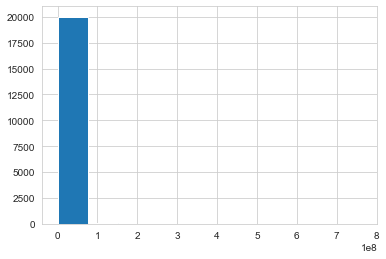

In [ ]:
data.last_price.hist()
None

##### 2.4.1.1. Среднее значение

In [ ]:
def number_runks(number: float) -> str:
    return '{0:,}'.format(int(number)).replace(',', ' ')

In [ ]:
'Средняя стоимость квартиры = ' + number_runks(data.last_price.mean()) + " рублей"

'Средняя стоимость квартиры = 6 441 391 рублей'

##### 2.4.1.2. Медиана

In [ ]:
last_price_median = data.last_price.median()
'Медиана стоимости квартиры = ' + number_runks(last_price_median) + " рублей"

'Медиана стоимости квартиры = 4 600 000 рублей'

##### 2.4.1.3. Дисперсия

In [ ]:
number_runks(data.last_price.std(ddof=0))

'10 904 632'

##### 2.4.1.4. Гистограмма на ограниченном масштабе

##### 2.4.1.4.1. Масштаб 1 медиана

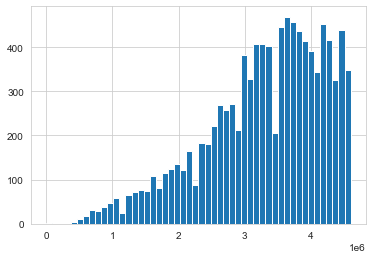

In [ ]:
data.last_price.hist(bins=50, range=[0, last_price_median])
None

Мы видим тенденцию на рост

##### 2.4.1.4.2. Масштаб 2 медианы

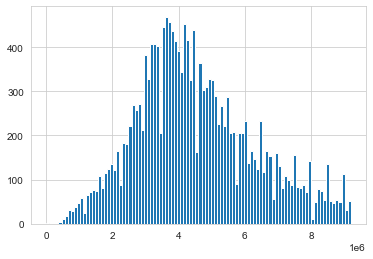

In [ ]:
data.last_price.hist(bins=100, range=[0, last_price_median * 2])
None

Нормальное распределение

##### 2.4.1.4.3. Масштаб 3 медианы

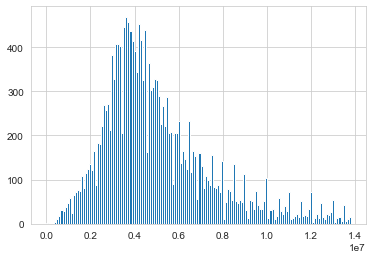

In [ ]:
data.last_price.hist(bins=150, range=[0, last_price_median * 3])
None

Распределение Пасуссона

##### 2.4.1.4.4. Масштаб 4 медианы

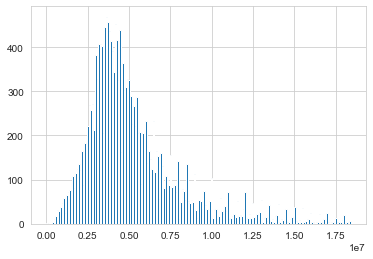

In [ ]:
data.last_price.hist(bins=200, range=[0, last_price_median * 4])
None

Распределение Пасуссона

##### 2.4.1.4.4. Масштаб 5 медианы

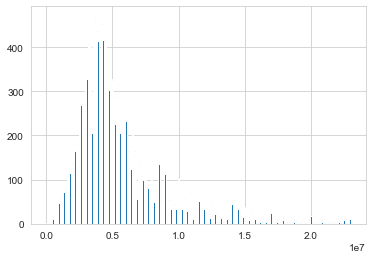

In [ ]:
data.last_price.hist(bins=250, range=[0, last_price_median * 5])
None

Распределение Пасуссона

##### 2.4.1.5. Описание данных

In [ ]:
data.last_price.describe()

count    2.006500e+04
mean     6.441391e+06
std      1.090490e+07
min      1.219000e+04
25%      3.420000e+06
50%      4.600000e+06
75%      6.700000e+06
max      7.630000e+08
Name: last_price, dtype: float64

##### 2.4.1.6. Комментарий
Оставим масштаб данных по цене квартиры в 5 медиан, все обьявления имеющие большую стоимость, не будем учитывать.

In [ ]:
data = data.loc[data.last_price <= last_price_median * 5]

Устранение редких и выбивающихся значений было выполнено в разделе "Обработка пропусков",
для того что бы корректно заполнить пропуски медианой и средним

## 3. Посчитайте и добавьте в таблицу новые столбцы

### 3.1. Цена одного квадратного метра

In [ ]:
data['price_m2'] = data.last_price / data.total_area

### 3.2. День недели публикации объявления (0 — понедельник, 1 — вторник и так далее);

In [ ]:
data['week_day'] = data.first_day_exposition.dt.dayofweek

### 3.3. Месяц публикации объявления

In [ ]:
data['month'] = data.first_day_exposition.dt.month

### 3.4. Год публикации объявления

In [ ]:
# data['year'] = data.first_day_exposition.dt.year
data.year.value_counts()

2017    7463
2018    7400
2016    2585
2015    1062
2019     996
2014     115
Name: year, dtype: int64

### 3.5. Тип этажа квартиры (значения — «первый», «последний», «другой»)

In [ ]:
def type_of_floor(row) -> str:
    '''Тип этажа квартиры (значения — «первый», «последний», «другой»)'''
    if row.floor == 1:
        return 'первый'
    elif row.floor == row.floors_total:
        return 'последний'
    else:
        return 'другой'

In [ ]:
data['type_of_floor'] = data.apply(type_of_floor, axis=1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year,price_m2,week_day,month,type_of_floor
1,7,3350000,40,2018-12-04,1,2.650391,11,18.593750,1,False,...,0,488,0,520,81,2018,83750.000000,1,12,первый
2,10,5196000,56,2015-08-20,2,2.650391,5,34.312500,4,False,...,1,90,2,574,558,2015,92785.714286,3,8,другой
4,2,10000000,100,2018-06-19,2,3.029297,14,32.000000,13,False,...,2,112,1,48,121,2018,100000.000000,1,6,другой
5,10,2890000,30,2018-09-10,1,2.650391,12,14.398438,5,False,...,0,488,0,520,55,2018,96333.333333,0,9,другой
6,6,3700000,37,2017-11-02,1,2.650391,26,10.601562,6,False,...,0,488,0,520,155,2017,100000.000000,3,11,другой


### 3.6. Расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [ ]:
data['city_centers_nearest_km'] = data.city_centers_nearest / 1000
data.city_centers_nearest_km.max()

65.105

Изменим тип данных, у новых столбцов

In [ ]:
data = data.astype({
    'price_m2': 'uint32',
    'week_day': 'uint8',
    'month': 'uint8',
    'year': 'uint16',
    'city_centers_nearest_km': 'uint8'
})

In [ ]:
gl_obj = data.select_dtypes(include=['object']).copy()
dow = gl_obj.type_of_floor
dow_cat = dow.astype('category')
data.type_of_floor = dow_cat

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19621 entries, 1 to 23698
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             19621 non-null  uint8         
 1   last_price               19621 non-null  uint32        
 2   total_area               19621 non-null  uint16        
 3   first_day_exposition     19621 non-null  datetime64[ns]
 4   rooms                    19621 non-null  uint8         
 5   ceiling_height           19621 non-null  float16       
 6   floors_total             19621 non-null  uint8         
 7   living_area              19621 non-null  float16       
 8   floor                    19621 non-null  uint8         
 9   is_apartment             19621 non-null  bool          
 10  studio                   19621 non-null  bool          
 11  open_plan                19621 non-null  bool          
 12  kitchen_area             19621 n

## 4. Проведите исследовательский анализ данных

### 4.1. Изучите следующие параметры объектов

#### 4.1.1. Общая площадь

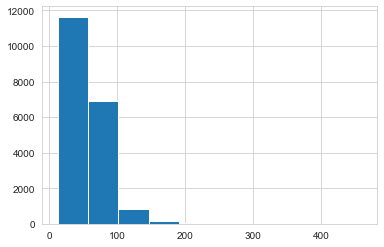

In [ ]:
data.total_area.hist()
None

Похоже на распределение **Пуасcона**

#### 4.1.2. Жилая площадь

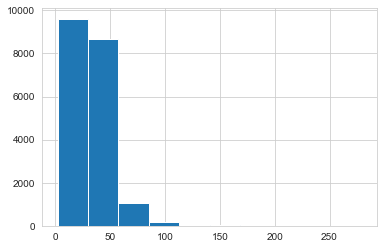

In [ ]:
data.living_area.hist()
None

Похоже на распределение **Пуасcона**

#### 4.1.3. Площадь кухни

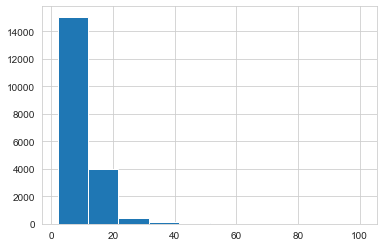

In [ ]:
data.kitchen_area.hist()
None

Похоже на распределение **Пуасcона**

#### 4.1.4. Цена объекта

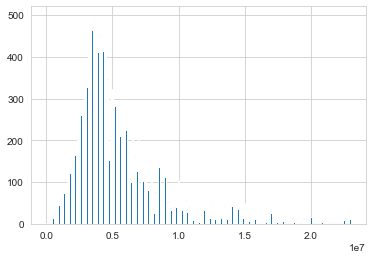

In [ ]:
data.last_price.hist(bins=250)
None

Похоже на **нормальное распределение**

#### 4.1.5. Количество комнат

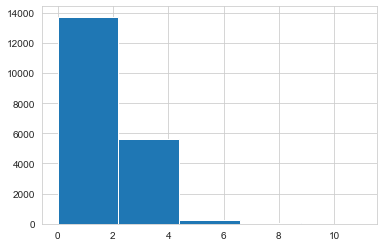

In [ ]:
data.rooms.hist(bins=5)
None

Похоже на распределение **Пуасcона**

#### 4.1.6. Высота потолков

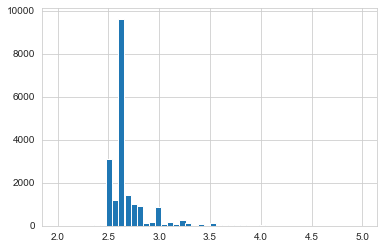

In [ ]:
data.ceiling_height.hist(bins=50, range=[2, 5])
None

Похоже на распределение **Пуасcона**

#### 4.1.7. Этаж квартиры

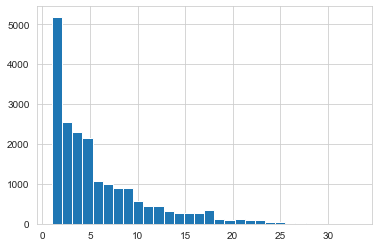

In [ ]:
data.floor.hist(bins=30)
None

Похоже на распределение **Пуасcона**

#### 4.1.8. Тип этажа квартиры («первый», «последний», «другой»)

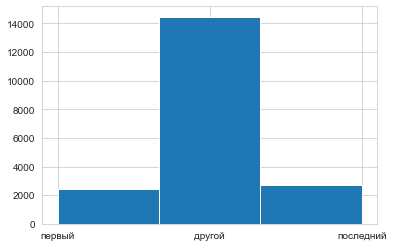

In [ ]:
data.type_of_floor.hist(bins=3)
None

Большинство квартин не на 1 и не на последнем этаже, это верно исходя из теор. вера

#### 4.1.9. Общее количество этажей в доме

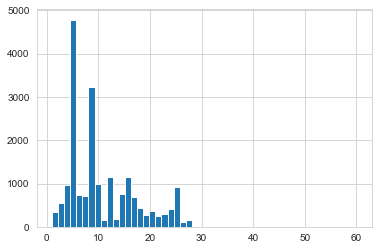

In [ ]:
data.floors_total.hist(bins=50)
None

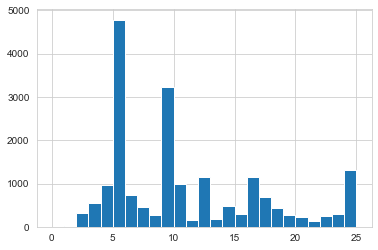

In [ ]:
data.floors_total.hist(bins=25, range=[0, 25])
None

Похоже на **нормальное распределение**

#### 4.1.10. Расстояние до центра города в метрах

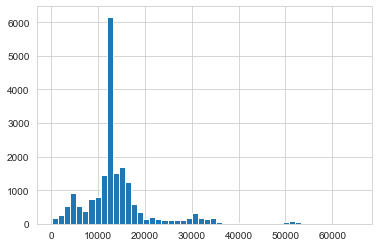

In [ ]:
data.city_centers_nearest.hist(bins=50)
None

Похоже на **нормальное распределение**

#### 4.1.11. Расстояние до ближайшего аэропорта

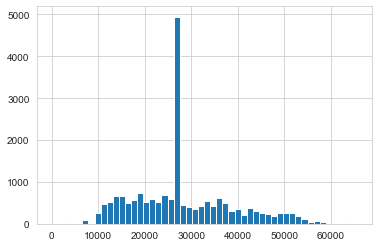

In [ ]:
data.airports_nearest.hist(bins=50)
None

Похоже на **нормальное распределение**

#### 4.1.12. Расстояние до ближайшего парка

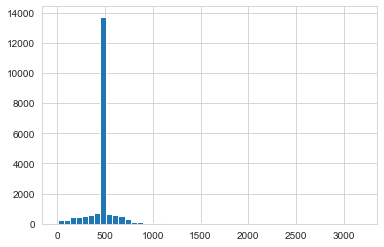

In [ ]:
data.parks_nearest.hist(bins=50)
None

Похоже на **нормальное распределение**

#### 4.1.13. День и месяц публикации объявления

#### 4.1.13.1. День публикации объявления

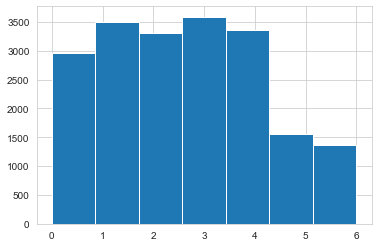

In [ ]:
data.week_day.hist(bins=7)
None

Большинство объявления публикуются в начале недели

#### 4.1.13.1. Месяц публикации объявления

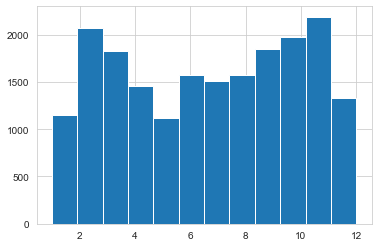

In [ ]:
data.month.hist(bins=12)
None

Видим снижение количества публикаций летом

### 4.2. Изучите, как быстро продавались квартиры (столбец days_exposition)

#### 4.2.1. Посторим гистограмму

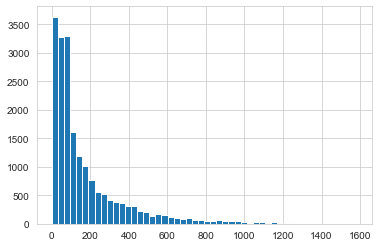

In [ ]:
data.days_exposition.hist(bins=50)
None

Похоже на распределение **Пуасcона**

#### 4.2.2. Посчитаем стреднее и медиану

##### 4.2.2.1. Среднее арифметическое

In [ ]:
int(data.days_exposition.mean())

176

##### 4.2.2.1. Медиана

In [ ]:
data.days_exposition.median()

95.0

#### 4.2.3. Комментарий

Среднее арифметическое время продажи квартир = 172 дня с момента публикации обьявления, среднее медианное время продажи = 95 дней с момента публикации обьявления. Среднее арифметическое больше, я думаю это связано с аномально долгими продажами неликвидных крватрир. Это значит, что в среднем квартира должня продаться за 95 дней. Неообычно долгии пррдажи - более 170 дней. Быстрые продажи - менее 95 дней с момента публикации обьявления.

### 4.3. Какие факторы больше всего влияют на общую (полную) стоимость объекта?

#### 4.3.1. Общей площади

##### 4.3.1.1. Диаграмма рассеяния

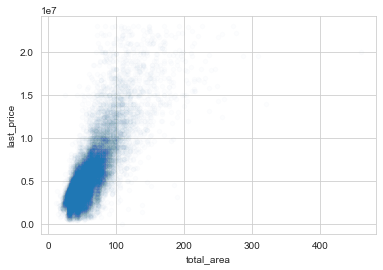

In [ ]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.01)
None

##### 4.3.1.2. hexbin - график, разделённый на шестиугольные области

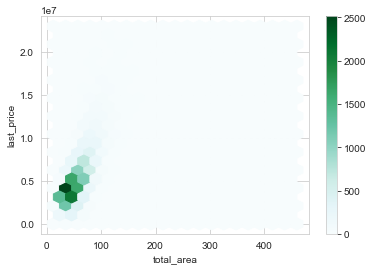

In [ ]:
data.plot(x='total_area', y='last_price', kind='hexbin', gridsize=20, sharex=False, grid=True)
None

##### 4.3.1.3. Корреляция

In [ ]:
data.total_area.corr(data.last_price)

0.7838658372922622

##### 4.3.1.4. Совместное распределение

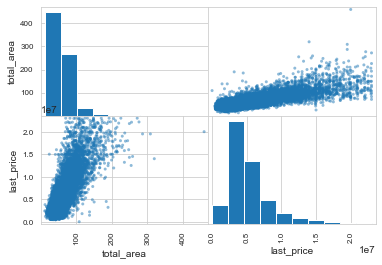

In [ ]:
pd.plotting.scatter_matrix(data[['total_area', 'last_price']])
None

##### 4.3.1.5. Комментарий
Коэфицент кореляции равен 0.78, анализируя диаграмму рассеивания и матрицу совместного распределения, мы можем найти нечто схожее с графиком f(x) = k * x, тоесть линейную зависимость в данных, таких образом, можно утверждать что с увеличением общей площади квартиры увеличивается стоимость жилья.

#### 4.3.2. Жилой площади

##### 4.3.2.1. Диаграмма рассеяния

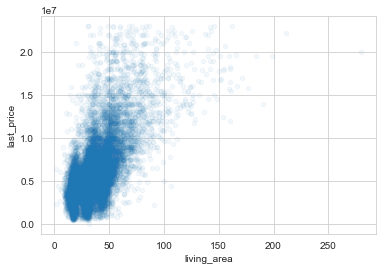

In [ ]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.05)
None

##### 4.3.2.2. hexbin - график, разделённый на шестиугольные области

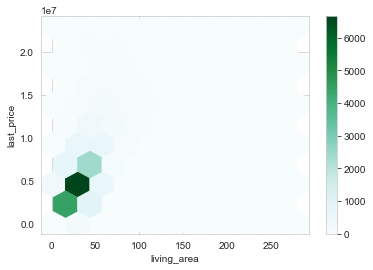

In [ ]:
data.plot(x='living_area', y='last_price', kind='hexbin', gridsize=10, sharex=False, grid=True)
None

##### 4.3.2.3. Корреляция

In [ ]:
data.living_area.corr(data.last_price)

0.6790979085041374

##### 4.3.2.4. Совместное распределение

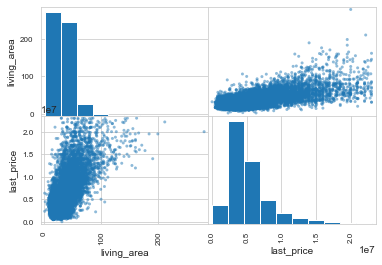

In [ ]:
pd.plotting.scatter_matrix(data[['living_area', 'last_price']])
None

##### 4.3.1.5. Комментарий
Коэфицент кореляции равен 0.68, анализируя диаграмму рассеивания и матрицу совместного распределения, мы можем найти нечто схожее с графиком f(x) = k * x, тоесть линейную зависимость в данных, таких образом, можно утверждать что с увеличением жилой площади квартиры увеличивается стоимость жилья.

#### 4.3.3. Площади кухни

##### 4.3.3.1. Диаграмма рассеяния

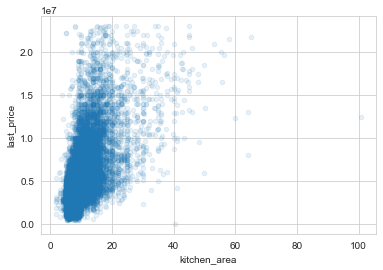

In [ ]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.1)
None

##### 4.3.3.2. hexbin - график, разделённый на шестиугольные области

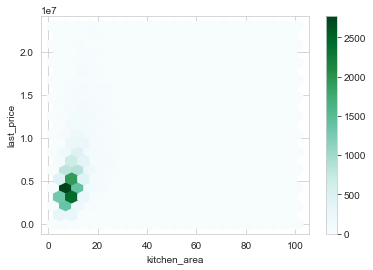

In [ ]:
data.plot(x='kitchen_area', y='last_price', kind='hexbin', gridsize=20, sharex=False, grid=True)
None

##### 4.3.3.3. Корреляция

In [ ]:
data.kitchen_area.corr(data.last_price)

0.5765381538465049

##### 4.3.3.4. Совместное распределение

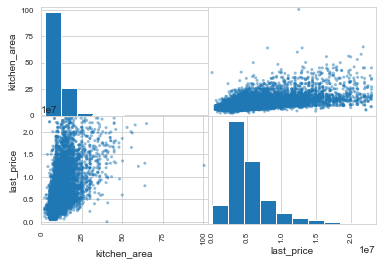

In [ ]:
pd.plotting.scatter_matrix(data[['kitchen_area', 'last_price']])
None

##### 4.3.3.5. Комментарий
Коэфицент кореляции равен 0.57, анализируя диаграмму рассеивания и матрицу совместного распределения, мы можем найти нечто схожее с графиком f(x) = k * x, тоесть линейную зависимость в данных, таких образом, можно утверждать что с увеличением площади кухни, незначительно увеличивается стоимость жилья. Я убежден что площадь кухни это зависимая от общей площади квартиры величина, и анализировать именно зависимость стоимости от площади кухни не имеет смыла. Ниже я постараюсь это доказать.

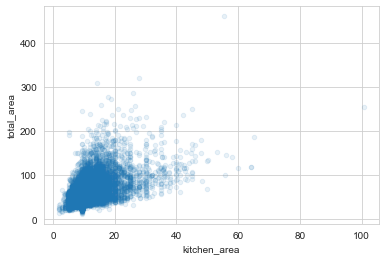

In [ ]:
data.plot(x='kitchen_area', y='total_area', kind='scatter', alpha=0.1)
None

In [ ]:
data.kitchen_area.corr(data.total_area)

0.5352571307630852

Коэфицент кореляции, 0.53 значит, что между этими данными есть линейная зависимость.

#### 4.3.4. Количества комнат

##### 4.3.4.1. Диаграмма рассеяния

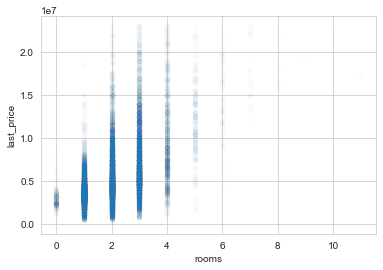

In [ ]:
data.plot(x='rooms', y='last_price', kind='scatter', alpha=0.01)
None

##### 4.3.4.2. hexbin - график, разделённый на шестиугольные области

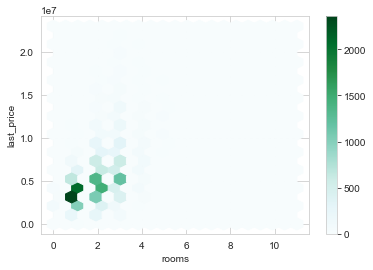

In [ ]:
data.plot(x='rooms', y='last_price', kind='hexbin', gridsize=20, sharex=False, grid=True)
None

##### 4.3.4.3. Корреляция

In [ ]:
data.rooms.corr(data.last_price)

0.529343862469776

##### 4.3.4.4. Совместное распределение

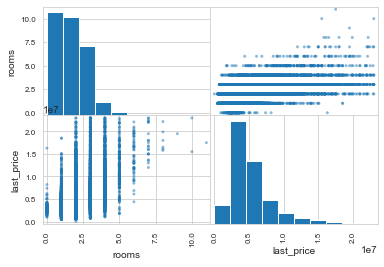

In [ ]:
pd.plotting.scatter_matrix(data[['rooms', 'last_price']])
None

##### 4.3.4.5. Комментарий
Коэфицент кореляции равен 0.52, значит что есть есть линейная зависимость

In [ ]:
print(data.living_area.corr(data.last_price))
print(data.rooms.corr(data.living_area))
print(data.rooms.corr(data.last_price))

0.6790979085041374
0.875992170701375
0.529343862469776


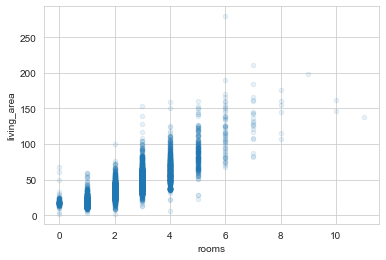

In [ ]:
data.plot(x='rooms', y='living_area', kind='scatter', alpha=0.1)
None

#### 4.3.5. Этажа, на котором расположена квартира (первый, последний, другой)

##### 4.3.5.1. Диаграмма рассеяния

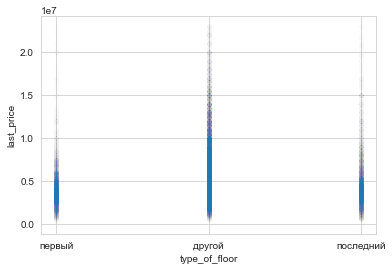

In [ ]:
data.plot(x='type_of_floor', y='last_price', kind='scatter', alpha=0.002)
None

##### 4.3.5.2. Среднее занчание для каждого из типов этажей

In [ ]:
data.pivot_table(index=['type_of_floor'], values=['last_price'], aggfunc='mean')

,last_price
type_of_floor,
другой,5.694150e+06
первый,4.427354e+06
последний,5.273458e+06


##### 4.3.5.3. Комментарий
Мы можем сделать вывод, что квартиры на 1 этаже в среднем, стоят дешевле

#### 4.3.6. Даты размещения (день недели, месяц, год)

##### 4.3.6.1. Диаграмма рассеяния

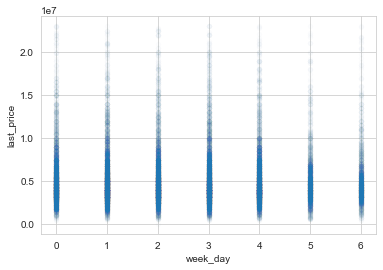

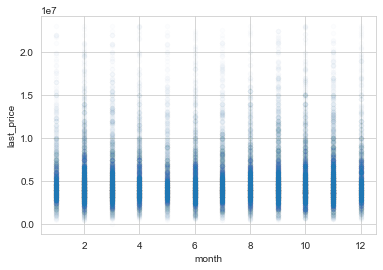

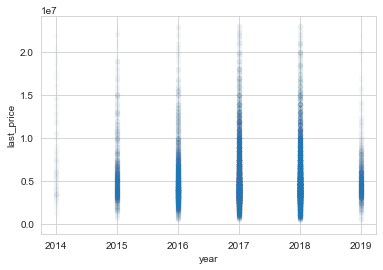

In [ ]:
data.plot(x='week_day', y='last_price', kind='scatter', alpha=0.01)
data.plot(x='month', y='last_price', kind='scatter', alpha=0.01)
data.plot(x='year', y='last_price', kind='scatter', alpha=0.01)
None

##### 4.3.6.2. hexbin - график, разделённый на шестиугольные области

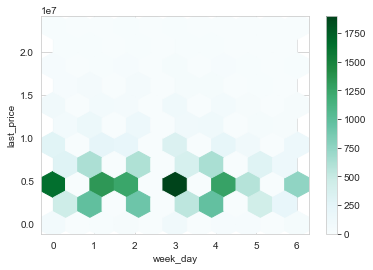

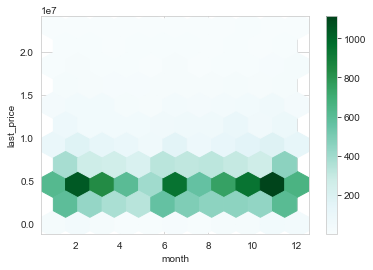

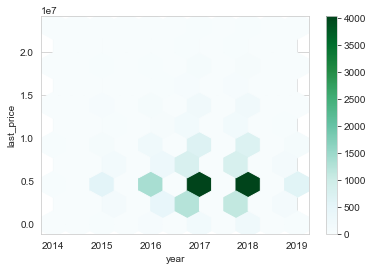

In [ ]:
data.plot(x='week_day', y='last_price', kind='hexbin', gridsize=10, sharex=False, grid=True)
data.plot(x='month', y='last_price', kind='hexbin', gridsize=10, sharex=False, grid=True)
data.plot(x='year', y='last_price', kind='hexbin', gridsize=10, sharex=False, grid=True)
None

##### 4.3.6.3. Корреляция

In [ ]:
print(data.week_day.corr(data.last_price))
print(data.month.corr(data.last_price))
print(data.year.corr(data.last_price))

-0.016801764259670848
0.014688800519213544
-0.054694241486516325


##### 4.3.6.4. Совместное распределение

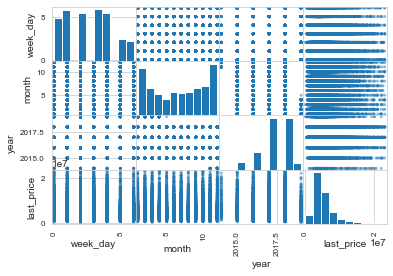

In [ ]:
pd.plotting.scatter_matrix(data[['week_day', 'month', 'year','last_price']])
None

##### 4.3.6.5. Комментарий
Коэфицент кореляции равен для всех трех фич, около 0, это значит что линейной зависимости цены квартиры от даты публикации обьявления нет.

### 4.4. ... Среднюю цену одного квадратного метра в 10 населённых пунктах ...

In [ ]:
data.locality_name.value_counts()[:10]

Санкт-Петербург    12972
 Мурино              487
 Шушары              386
Всеволожск           344
Пушкин               312
Колпино              306
 Парголово           283
Гатчина              271
 Кудрово             262
Петергоф             186
Name: locality_name, dtype: int64

In [ ]:
data.price_m2

1         83750
2         92785
4        100000
5         96333
6        100000
          ...  
23693     74193
23694     72932
23695     52542
23696     44642
23698     42187
Name: price_m2, Length: 19621, dtype: uint32

In [ ]:
top_locals_pt = data.pivot_table(index='locality_name', values='price_m2', aggfunc=['mean', 'count'])
top_locals_pt = top_locals_pt.loc[top_locals_pt.iloc[:, 1] >= 197].sort_values(by=[('mean', 'price_m2')], ascending=False)
top_locals_pt

,mean,count
,price_m2,price_m2
locality_name,,
Санкт-Петербург,108619.967468,12972
Пушкин,102368.919872,312
Кудрово,93259.072519,262
Парголово,90656.388693,283
Мурино,87004.408624,487
Шушары,78762.702073,386
Колпино,75201.879085,306
Гатчина,68630.088561,271


#### 4.4.1. Самая высокая средняя стоимость за квадратный метр
В городе Санкт-Петербург, она составляет 109 439 рублей

#### 4.4.2. Самая низкая средняя стоимость за квадратный метр
В городе Всеволожск, она составляет 67 663 рублей

### 4.5. ... Cреднюю цену каждого километра в Санкт-Петербурге ...

In [ ]:
spb = data.loc[data.locality_name == 'Санкт-Петербург']
spb.locality_name.astype('object')
spb_pt = spb.pivot_table(index=['city_centers_nearest_km'], values=['last_price'])
spb_pt

,last_price
city_centers_nearest_km,
0,1.025896e+07
1,1.073479e+07
2,9.928495e+06
3,9.078453e+06
4,9.800330e+06
5,9.192620e+06
6,8.114458e+06
7,8.358223e+06
8,7.597956e+06


In [ ]:
number_runks(spb_pt.std(ddof=0)) # Дисперсия

'2 132 148'

In [ ]:
number_runks(spb_pt.mean()) # Средняя стоимость 1 км близости к центру города

'6 389 383'

In [ ]:
number_runks(spb_pt.median()) # Медиана

'5 797 053'

In [ ]:
sns.lineplot(spb_pt)

ValueError: If using all scalar values, you must pass an index

In [ ]:
spb.last_price.corr(spb.city_centers_nearest_km)

In [ ]:
data.plot(x='city_centers_nearest_km', y='last_price', kind='scatter', alpha=0.01)
None

Стоимость квартиры обратно пропорциональна расстоянию до центра города

## 5. Общий вывод

### 5.1. Общая информация
В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

### 5.2. Предобработка данных
##### 5.2.1. Обработка пропусков 
**Пропуски из-за технической ошибки**

**Обнаружены в следующий столбцах, которы должны были быть заполнены "картографически"**
1. airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
2. city_centers_nearest — расстояние до центра города (м)
3. locality_name — название населённого пункта
4. parks_around3000 — число парков в радиусе 3 км
5. parks_nearest — расстояние до ближайшего парка (м)
6. ponds_around3000 — число водоёмов в радиусе 3 км
7. ponds_nearest — расстояние до ближайшего водоёма (м)
**Иная техническая ошибка**
1. days_exposition — сколько дней было размещено объявление (от публикации до снятия)
**Пропуски из-за человеческого фактора**
1. balcony — число балконов
2. ceiling_height — высота потолков (м)
3. floors_total — всего этажей в доме
4. is_apartment — апартаменты (булев тип)
5. kitchen_area — площадь кухни в квадратных метрах (м²)
6. living_area — жилая площадь в квадратных метрах (м²)
**Комментарий**
Я убежден что есть возможность автоматического заполнения данных:
1. floors_total -> с помощью геометки пользователя определяем конкретный дом, храним в БД данные об этом здании
2. ceiling_height —> аналогично
3. is_apartment —> аналогично
##### 5.2.2. Изменение типов данных
Типы данных были земенены, у числовых был изменен обьем памяти, строковые типы были заменены на категориальные. Это было сделано для экономии оперативной памяти.
##### 5.2.3. Работа с дубликатами
Явные дубликаты не были обнаружены, неявные дубликаты были удалены, так же была осуществена проверка с помощью алгоритма "Расстояние Левинштейна".
##### 5.2.4. Обработка аномальных занчений
Были выбросы в столбце last_price. Я уменьшил масштаб данных, до 5 медиан, добился распределения данных "Пауссона" на графике гистограммы.

### 5.3. Добавление новых столбцов
Мною были добавлены новые столбцы:
1. цена одного квадратного метра
2. день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
3. месяц публикации объявления
4. год публикации объявления
5. тип этажа квартиры (значения — «первый», «последний», «другой»)
6. расстояние до центра города в километрах

### 5.4. Исследовательский анализ данных
#### 5.4.1. Изучение параметров
1. Общая площадь имеет распределение Пуассона
2. Жилая площадь имеет распределение Пуассона
3. Площадь кухни имеет распределение Пуассона
4. Цена объекта имеет нормальное распределение
5. Количество комнат имеет распределение Пуассона
6. Высота потолоков имеет распределение Пуассона
7. Этаж квартиры распределение Пуассона
8. Тип этажа квартиры: Большинство квартин не на 1 и не на последнем этаже, это верно исходя из теор. вера
9. Общее количество этажей в доме имеет нормальное распределение
10. Расстояние до центра города в метрах имеет нормальное распределение
11. Расстояние до ближайшего аэропорта имеет нормальное распределение
12. Расстояние до ближайшего парка имеет нормальное распределение
13. День публикации объявления. Большинство объявления публикуются в начале недели
14. Месяц публикации объявления. Видим снижение количества публикаций летом
#### 5.4.2. Исследование скорости продажи квартиры
1. Гистограмма: данные (срок продажи объявлений) имеют распределение Пуассона
2. Среднее время продажи квартир - 170 дней.
3. Медианное время продажи квартир - 95 дней. 
4. Среднее арифметическое больше, я думаю это связано с аномально долгими продажами неликвидных крватрир. Это значит, что в среднем квартира должня продаться за 95 дней. Неообычно долгии пррдажи - более 170 дней. Быстрые продажи - менее 95 дней с момента публикации обьявления.
#### 5.4.3. Влияние факторов на срок продажи квартиры
1. **Общаяя площадь.** Коэфицент кореляции равен 0.78, анализируя диаграмму рассеивания и матрицу совместного распределения, мы можем найти нечто схожее с графиком f(x) = k * x, тоесть линейную зависимость в данных, таких образом, можно утверждать что с увеличением общей площади квартиры увеличивается стоимость жилья.
2. **Жилая площадь.** Коэфицент кореляции равен 0.68, анализируя диаграмму рассеивания и матрицу совместного распределения, мы можем найти нечто схожее с графиком f(x) = k * x, тоесть линейную зависимость в данных, таких образом, можно утверждать что с увеличением жилой площади квартиры увеличивается стоимость жилья.
3. **Площадь кухни.** Коэфицент кореляции равен 0.57, анализируя диаграмму рассеивания и матрицу совместного распределения, мы можем найти нечто схожее с графиком f(x) = k * x, тоесть линейную зависимость в данных, таких образом, можно утверждать что с увеличением площади кухни, незначительно увеличивается стоимость жилья. Я убежден что площадь кухни это зависимая от общей площади квартиры величина, и анализировать именно зависимость стоимости от площади кухни не имеет смыла.
4. **Количество комнат.** Коэфицент кореляции равен 0.52, значит что есть есть линейная зависимость.
5. **Тип этажа.** Мы можем сделать вывод, что квартиры на 1 этаже в среднем, стоят дешевле
6. **Дата размещения.** Коэфицент кореляции равен для всех трех фич, около 0, это значит что линейной зависимости цены квартиры от даты публикации обьявления нет.
#### 5.4.4. Средняя цена одного квадратного метра
1. Самая высокая средняя стоимость за квадратный метр - В городе Санкт-Петербург, она составляет 109 439 рублей
2. Самая низкая средняя стоимость за квадратный метр - В городе Всеволожск, она составляет 67 663 рублей
#### 5.4.5. Средняя стоимость километра от центра говрода в СПБ
1. Стоимость квартиры обратно пропорциональна расстоянию до центра города
2. 6 473 304 рублей - средняя стоимость 1 км близости к центру города
3. 2 123 585 рублей - дисперсия
4. 5 857 299 рублей - медиана